# Estimator Analysis

Understand the Logistic Regression estimator that was chosen as the best performer in [parameter_optimization](parameter_optimization.ipynb).

### Get the data  from [property_calculations](property_calculations.ipynb) and grid search data from [parameter_optimization](parameter_optimization.ipynb).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os.path as path
import pickle

# Load property_array from property_calculations FEMA-JECFA database
BASE_DATA_PATH = path.join(path.expanduser('~'),
                           'Dropbox',
                           'bymt',
                           'data_dumps',
                           'chem_project',
                           'fp')

dataset_path = path.join(BASE_DATA_PATH,
                         'property_calculations',
                         'dataset.pkl')

with open(dataset_path, 'rb') as f:
    dataset = pickle.load(f)
    
train_features = dataset['train features']
train_labels = dataset['train labels']
test_features = dataset['test features']
test_labels = dataset['test labels']

grids_path = path.join(BASE_DATA_PATH,
                      'parameter_optimization',
                      'grids.pkl')

with open(grids_path, 'rb') as g:
    grids = pickle.load(g)

### Logistic Regression estimator analysis

In [2]:
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(class_weight='balanced', random_state=42)
LR_params = {'estimator': [LR],
             'estimator__C': 10.0 ** -np.arange(-4, 4),
             'estimator__solver': ['lbfgs', 'sag', 'newton-cg']}

In [4]:
lr_grid = grids['lr']
lr_grid.best_params_

{'estimator': LogisticRegression(C=0.10000000000000001, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
           solver='lbfgs', tol=0.0001, verbose=0, warm_start=False),
 'estimator__C': 0.10000000000000001,
 'estimator__solver': 'lbfgs'}

In [ ]:
from sklearn.model_selection import cross_val_score

lr_grid = grids['lr']
lr = lr_grid.best_estimator_
lr_roc = cross_val_score(lr, train_features, train_labels, cv=4, scoring='roc_auc')

In [18]:
print('Mean Area under Receiver Operating Characteristic curve: {:.3f}' 
      .format(np.mean(lr_roc)))

Mean Area under Receiver Operating Characteristic curve: 0.850


In [ ]:
lr_ap_scores = cross_val_score(lr, 
                               train_features, train_labels,
                               cv=4, scoring='average_precision')

In [13]:
long_string = 'Area under recall_precision curve is {:.1f} times\
 greater than expected if clasifier were random'

proportion_positives = sum(train_labels)/train_labels.shape[0]
print(long_string 
      .format(np.mean(lr_ap_scores)/proportion_positives))

Area under recall_precision curve is 4.4 times greater than expected if clasifier were random


In [20]:
from sklearn.model_selection import validation_curve
from sklearn.metrics import matthews_corrcoef, make_scorer

math_scorer = make_scorer(matthews_corrcoef)

param_range_C = 10.0 ** -np.arange(-4, 4)

train_scores_C, test_scores_C = validation_curve(
        lr,
        train_features, train_labels,
        param_name='estimator__C', 
        param_range=param_range_C,
        cv=4, scoring=math_scorer, 
        n_jobs=-1, verbose=2
)

[CV] estimator__C=10000.0 ............................................
[CV] estimator__C=1000.0 .............................................
[CV] estimator__C=100.0 ..............................................
[CV] estimator__C=10.0 ...............................................
[CV] .............................. estimator__C=1000.0, total=   3.7s
[CV] estimator__C=1.0 ................................................
[CV] ............................. estimator__C=10000.0, total=   3.9s
[CV] estimator__C=0.1 ................................................
[CV] ................................ estimator__C=10.0, total=   3.6s
[CV] estimator__C=0.01 ...............................................
[CV] ............................... estimator__C=100.0, total=   3.8s
[CV] estimator__C=0.001 ..............................................
[CV] ............................... estimator__C=0.001, total=   1.1s
[CV] estimator__C=10000.0 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  16 out of  32 | elapsed:   13.5s remaining:   13.5s


[CV] ............................. estimator__C=10000.0, total=   4.2s
[CV] .............................. estimator__C=1000.0, total=   4.1s
[CV] estimator__C=1.0 ................................................
[CV] estimator__C=0.1 ................................................
[CV] ............................... estimator__C=100.0, total=   4.3s
[CV] estimator__C=0.01 ...............................................
[CV] ................................ estimator__C=10.0, total=   4.3s
[CV] estimator__C=0.001 ..............................................
[CV] ............................... estimator__C=0.001, total=   1.2s
[CV] estimator__C=10000.0 ............................................
[CV] ................................ estimator__C=0.01, total=   1.5s
[CV] estimator__C=1000.0 .............................................
[CV] ................................. estimator__C=1.0, total=   3.8s
[CV] estimator__C=100.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   27.3s finished


In [81]:
def plot_val_curve(train_scores, test_scores, param_range, xlabel='modified parameter'):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title("Validation Curve")
    plt.xlabel(xlabel)
    plt.ylabel("Matthews correlation")
    plt.grid()
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

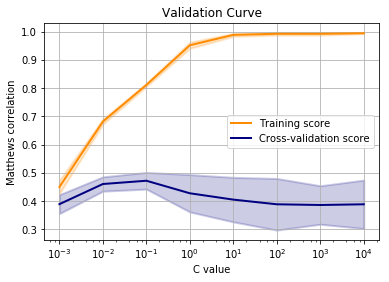

In [82]:
plot_val_curve(train_scores_C, test_scores_C, param_range_C, xlabel='C value')

In [23]:
param_range_solver = ['lbfgs', 'sag', 'newton-cg']

train_scores_solver, test_scores_solver = validation_curve(
        lr,
        train_features, train_labels,
        param_name='estimator__solver', 
        param_range=param_range_solver,
        cv=4, scoring=math_scorer, 
        n_jobs=-1, verbose=2
)

[CV] estimator__solver=lbfgs .........................................
[CV] estimator__solver=sag ...........................................
[CV] estimator__solver=newton-cg .....................................
[CV] estimator__solver=lbfgs .........................................
[CV] .......................... estimator__solver=lbfgs, total=   2.1s
[CV] estimator__solver=sag ...........................................
[CV] .......................... estimator__solver=lbfgs, total=   2.4s
[CV] estimator__solver=newton-cg .....................................
[CV] ...................... estimator__solver=newton-cg, total=   3.4s
[CV] estimator__solver=lbfgs .........................................
[CV] .......................... estimator__solver=lbfgs, total=   2.0s
[CV] estimator__solver=sag ...........................................
[CV] ...................... estimator__solver=newton-cg, total=   3.1s
[CV] estimator__solver=newton-cg .....................................
[CV] .

[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    8.7s remaining:    8.7s


[CV] .......................... estimator__solver=lbfgs, total=   1.3s
[CV] estimator__solver=sag ...........................................


/Users/TRN/anaconda/envs/chemproject/lib/python3.5/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................ estimator__solver=sag, total=  13.7s
[CV] estimator__solver=newton-cg .....................................


/Users/TRN/anaconda/envs/chemproject/lib/python3.5/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................ estimator__solver=sag, total=  13.5s
[CV] ...................... estimator__solver=newton-cg, total=   2.5s


/Users/TRN/anaconda/envs/chemproject/lib/python3.5/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................ estimator__solver=sag, total=  12.4s


/Users/TRN/anaconda/envs/chemproject/lib/python3.5/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................ estimator__solver=sag, total=  10.8s


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   21.1s finished


In [68]:
def plot_val_bar(train_scores, test_scores, param_range):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    locs = np.arange(len(param_range))
    
#     fig = plt.figure() 
    fig, ax = plt.subplots()
    ax.set_title('Validation Bars')
    ax.set_ylabel('Matthews correlation')
    ax.set_xlabel('Solver')
    ax.bar(locs, train_scores_mean, yerr=train_scores_std,
           width=-0.4, align='edge',
           label='Training score', 
           color='darkorange', alpha=0.5)
    ax.bar(locs, test_scores_mean, yerr=test_scores_std,
           width=0.4, align='edge',
           label='Test score',
           color='navy', alpha=0.5)
    ax.set_xticks(locs)
    ax.set_xticklabels(param_range)
    ax.legend(loc='lower right')
    plt.show()

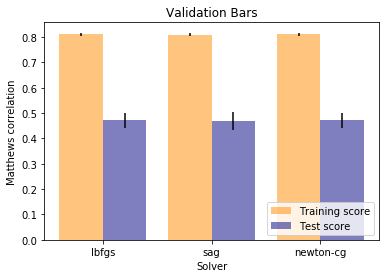

In [69]:
plot_val_bar(train_scores_solver, test_scores_solver, param_range_solver)

In [79]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring=math_scorer)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

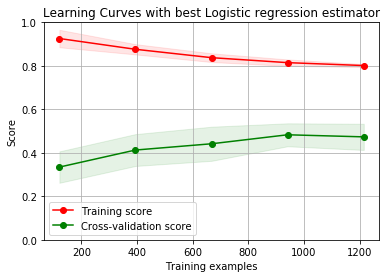

In [80]:
title = 'Learning Curves with best Logistic regression estimator'
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

plot_learning_curve(lr, title, train_features, train_labels, 
                    ylim=(0, 1), cv=cv, n_jobs=-1)

plt.show()